In [197]:
import warnings
warnings.filterwarnings("ignore")

#### Generating synthetic dataset

In [357]:
import pandas as pd
import random
from datetime import datetime, timedelta

def generate_synthetic_data(
    num_users=600,
    num_products=60,
    months=6,
    random_seed=42
):
    """
    Generates a more realistic synthetic dataset with:
    - User-level preferences (category distribution, budget factor, purchase frequency)
    - Category-based product catalog
    - Time-based purchases

    Adjusted to ensure ~8000+ total records by setting purchase_freq in a suitable range.
    """
    random.seed(random_seed)
    np.random.seed(random_seed)

    # 1. Define categories and base price ranges
    categories = ['Electronics', 'Clothing', 'Groceries', 'Home & Kitchen', 'Books', 'Toys']
    category_price_ranges = {
        'Electronics': (100, 2000),
        'Clothing': (10, 200),
        'Groceries': (1, 50),
        'Home & Kitchen': (20, 500),
        'Books': (5, 100),
        'Toys': (5, 80)
    }
    
    # 2. Distribute products among categories
    product_ids = [f'P{str(i).zfill(4)}' for i in range(1, num_products + 1)]
    product_categories = np.random.choice(categories, size=num_products, replace=True)

    # 3. Create a dictionary to store each product's base price range
    product_catalog = {}
    for i, pid in enumerate(product_ids):
        cat = product_categories[i]
        base_min, base_max = category_price_ranges[cat]
        # Pick a random sub-range within the global category range
        local_min = random.uniform(base_min, base_max * 0.7)
        local_max = random.uniform(local_min, base_max)
        product_catalog[pid] = {
            'category': cat,
            'price_range': (local_min, local_max)
        }
    
    # 4. Generate user profiles
    #    Each user has:
    #    - category distribution (Dirichlet-like or exponential-based)
    #    - budget factor (0.5 ~ 2.0)
    #    - purchase frequency (# of purchases in 6 months) in a range ensuring ~8000 total
    user_ids = [f'C{str(i).zfill(4)}' for i in range(1, num_users + 1)]
    
    user_profiles = {}
    for uid in user_ids:
        # random category preference
        raw_prefs = np.random.exponential(scale=1.0, size=len(categories))
        cat_prefs = raw_prefs / raw_prefs.sum()  # normalize

        budget_factor = np.random.uniform(0.5, 2.0)
        # Adjust the frequency range to ensure ~8000+ total interactions
        # e.g., 3 to 25 => average 14 => 14 * 600 = 8400
        purchase_freq = np.random.randint(3, 25)

        user_profiles[uid] = {
            'category_prefs': dict(zip(categories, cat_prefs)),
            'budget_factor': budget_factor,
            'purchase_freq': purchase_freq
        }

    # 5. Simulation of purchases over 'months' months
    start_date = datetime.now() - timedelta(days=months*30)
    
    records = []
    
    for uid in user_ids:
        profile = user_profiles[uid]
        freq = profile['purchase_freq']
        
        # For each "purchase event"
        for _ in range(freq):
            # pick a random date in [0..months*30]
            days_offset = random.randint(0, months*30)
            purchase_date = start_date + timedelta(days=days_offset)
            
            # pick a category from user distribution
            cat_choice = np.random.choice(categories, p=list(profile['category_prefs'].values()))
            # from that category, pick a product that belongs to cat_choice
            cat_products = [pid for pid, info in product_catalog.items() if info['category'] == cat_choice]
            if not cat_products:
                continue
            pid = random.choice(cat_products)
            
            # pick a price from product's local range
            local_min, local_max = product_catalog[pid]['price_range']
            base_price = random.uniform(local_min, local_max)
            
            # multiply by user budget factor
            purchase_amount = base_price * profile['budget_factor']
            
            # create record
            records.append([
                uid,
                pid,
                cat_choice,
                round(purchase_amount, 2),
                purchase_date
            ])
    
    # Create DataFrame
    df_synth = pd.DataFrame(records, columns=['Customer ID', 'Product ID', 'Product Category', 'Purchase Amount', 'Purchase Date'])
    return df_synth


if __name__ == "__main__":
    # You can tweak num_users, num_products, months as needed
    df = generate_synthetic_data(num_users=600, num_products=60, months=7, random_seed=42)
    display(df.head(10))
    print("Total rows:", len(df))
    # Save to CSV if desired:
    df.to_csv("synthetic_data.csv", index=False)


,Customer ID,Product ID,Product Category,Purchase Amount,Purchase Date
0,C0001,P0016,Home & Kitchen,358.43,2025-03-01 11:48:38.410071
1,C0001,P0060,Home & Kitchen,235.68,2025-03-05 11:48:38.410071
2,C0001,P0057,Clothing,79.64,2024-08-18 11:48:38.410071
3,C0001,P0011,Home & Kitchen,411.00,2024-08-22 11:48:38.410071
4,C0001,P0035,Toys,24.06,2025-03-12 11:48:38.410071
5,C0001,P0060,Home & Kitchen,237.21,2024-10-18 11:48:38.410071
6,C0001,P0011,Home & Kitchen,382.49,2024-09-07 11:48:38.410071
7,C0001,P0011,Home & Kitchen,418.07,2025-03-14 11:48:38.410071
8,C0002,P0005,Books,61.77,2025-01-01 11:48:38.410071
9,C0002,P0055,Clothing,169.38,2024-12-17 11:48:38.410071


Total rows: 8291


In [531]:
#Display top 5 rows
df = pd.read_csv("synthetic_data.csv")
df.head()

,Customer ID,Product ID,Product Category,Purchase Amount,Purchase Date
0,C0001,P0016,Home & Kitchen,358.43,2025-03-01 11:48:38.410071
1,C0001,P0060,Home & Kitchen,235.68,2025-03-05 11:48:38.410071
2,C0001,P0057,Clothing,79.64,2024-08-18 11:48:38.410071
3,C0001,P0011,Home & Kitchen,411.00,2024-08-22 11:48:38.410071
4,C0001,P0035,Toys,24.06,2025-03-12 11:48:38.410071


## EDA & Insights

----- BASIC INFO -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8291 entries, 0 to 8290
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Customer ID       8291 non-null   object 
 1   Product ID        8291 non-null   object 
 2   Product Category  8291 non-null   object 
 3   Purchase Amount   8291 non-null   float64
 4   Purchase Date     8291 non-null   object 
dtypes: float64(1), object(4)
memory usage: 324.0+ KB

----- DESCRIPTIVE STATISTICS -----


,Customer ID,Product ID,Product Category,Purchase Amount,Purchase Date
count,8291,8291,8291,8291.000000,8291
unique,600,60,6,NaN,211
top,C0302,P0054,Books,NaN,2025-01-11 11:48:38.410071
freq,24,221,1466,NaN,61
mean,NaN,NaN,NaN,314.765365,NaN
std,NaN,NaN,NaN,509.149518,NaN
min,NaN,NaN,NaN,1.220000,NaN
25%,NaN,NaN,NaN,42.805000,NaN
50%,NaN,NaN,NaN,89.100000,NaN
75%,NaN,NaN,NaN,317.935000,NaN



----- MISSING VALUES -----
Customer ID         0
Product ID          0
Product Category    0
Purchase Amount     0
Purchase Date       0
dtype: int64


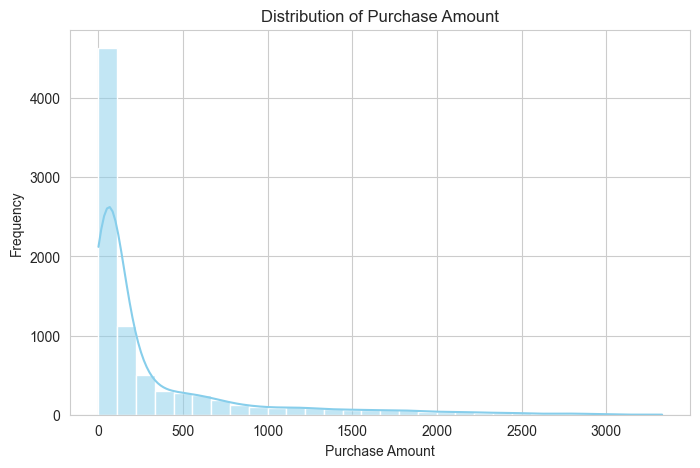

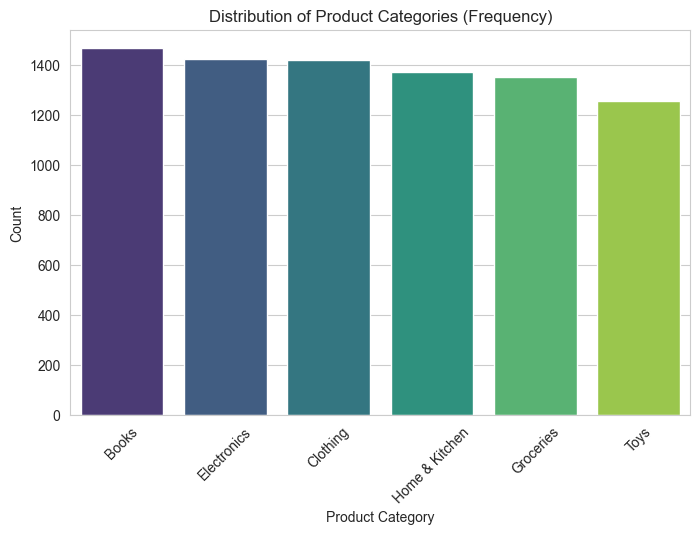

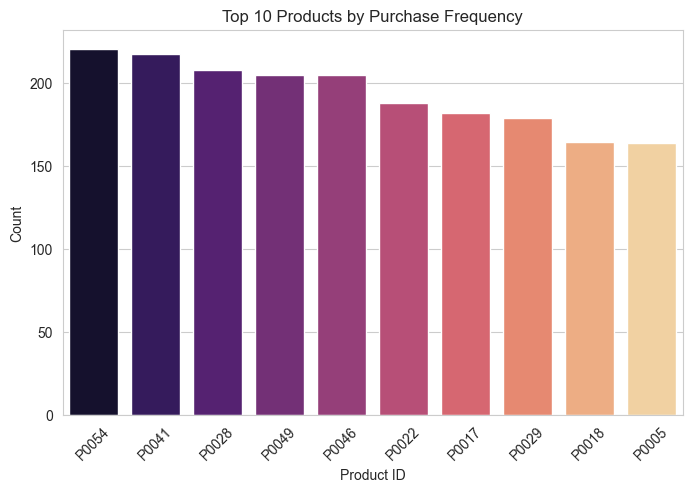

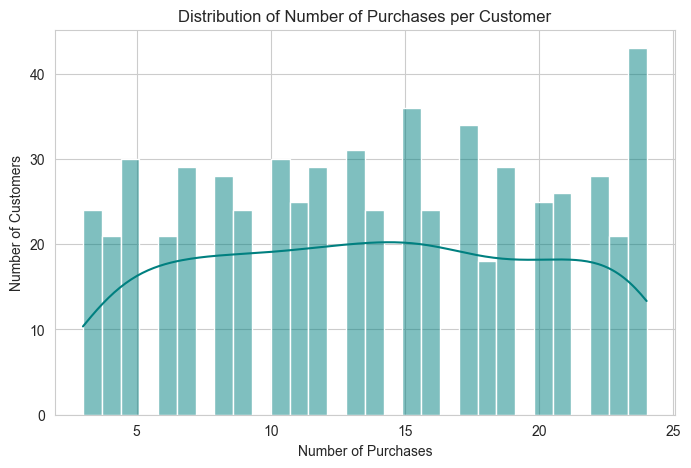

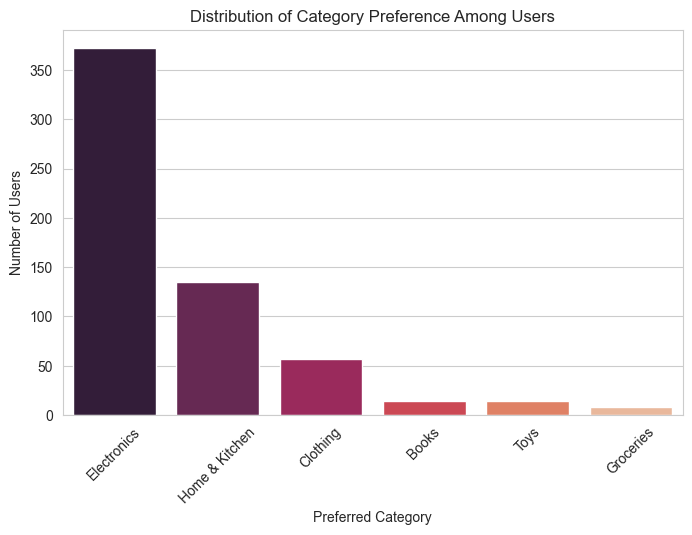

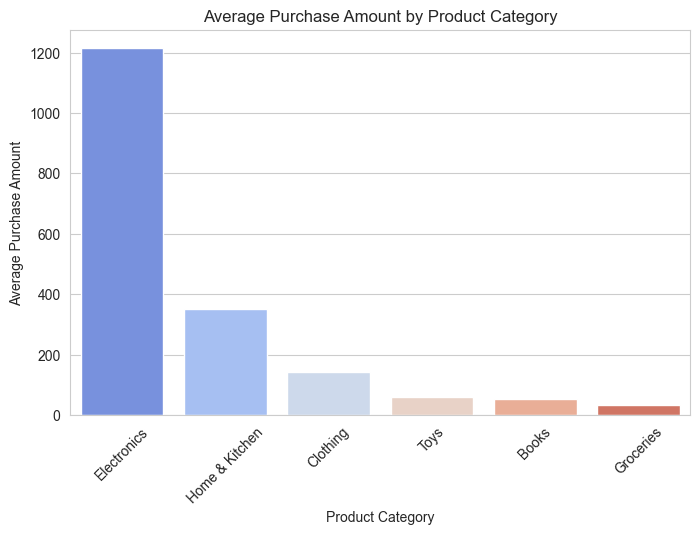

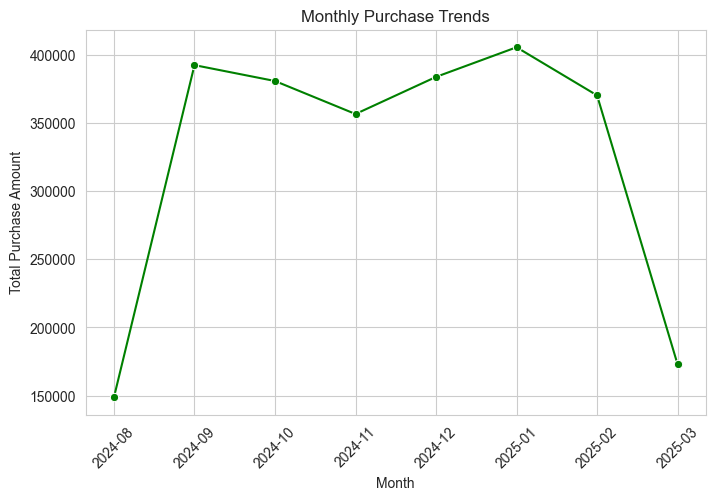

In [646]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_style("whitegrid")

# 1. Load the synthetic data
#    Replace 'synthetic_customer_data.csv' with your actual file path if needed
df = pd.read_csv('synthetic_data.csv')

# 2. Basic Information
print("----- BASIC INFO -----")
df.info()
print("\n----- DESCRIPTIVE STATISTICS -----")
display(df.describe(include='all'))

# 3. Check for missing values
print("\n----- MISSING VALUES -----")
print(df.isnull().sum())

# 4. Distribution of Purchase Amount
plt.figure(figsize=(8, 5))
sns.histplot(df['Purchase Amount'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Purchase Amount")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")
plt.show()

# 5. Distribution of Product Categories (Frequency)
plt.figure(figsize=(8, 5))
category_counts = df['Product Category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title("Distribution of Product Categories (Frequency)")
plt.xlabel("Product Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# 6. Top 10 Products by Purchase Frequency
top_products = df['Product ID'].value_counts().head(10)
plt.figure(figsize=(8, 5))
sns.barplot(x=top_products.index, y=top_products.values, palette='magma')
plt.title("Top 10 Products by Purchase Frequency")
plt.xlabel("Product ID")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# 7. User Purchase Frequency
user_purchase_counts = df['Customer ID'].value_counts()
plt.figure(figsize=(8, 5))
sns.histplot(user_purchase_counts, bins=30, kde=True, color='teal')
plt.title("Distribution of Number of Purchases per Customer")
plt.xlabel("Number of Purchases")
plt.ylabel("Number of Customers")
plt.show()

# 8. Distribution of User Preferences
#    Define 'preference' as the category on which each user spends the most in total
user_spend_by_category = df.groupby(['Customer ID', 'Product Category'])['Purchase Amount'].sum().reset_index()

#    For each user, find the category with the maximum spend
user_max_category = user_spend_by_category.loc[
    user_spend_by_category.groupby('Customer ID')['Purchase Amount'].idxmax()
].reset_index(drop=True)

user_max_category.rename(columns={'Product Category': 'Preferred Category'}, inplace=True)

#    Distribution of preferred categories among users
pref_counts = user_max_category['Preferred Category'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=pref_counts.index, y=pref_counts.values, palette='rocket')
plt.title("Distribution of Category Preference Among Users")
plt.xlabel("Preferred Category")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.show()

# 9. Average Purchase Amount by Category
category_avg_spend = df.groupby('Product Category')['Purchase Amount'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=category_avg_spend.index, y=category_avg_spend.values, palette='coolwarm')
plt.title("Average Purchase Amount by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Average Purchase Amount")
plt.xticks(rotation=45)
plt.show()

# 10. Time-based Analysis (Optional)
#     Convert 'Purchase Date' to datetime if not already, then plot monthly or daily trends
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'], errors='coerce')

# Monthly Purchase Trends
df['Month'] = df['Purchase Date'].dt.to_period('M')
monthly_sales = df.groupby('Month')['Purchase Amount'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Month'].astype(str)

plt.figure(figsize=(8, 5))
sns.lineplot(x='Month', y='Purchase Amount', data=monthly_sales, marker='o', color='green')
plt.title("Monthly Purchase Trends")
plt.xlabel("Month")
plt.ylabel("Total Purchase Amount")
plt.xticks(rotation=45)
plt.show()



### Key insights based on EDA on data

1. P0054 and P0041 are the most popular product among customers with highest number of purchases (~250)
2. Most preferred category by customers is Electronics and least preferred is Groceries.
3. Distribution of purchase amount is right-skewed, which means lower number of people have purchase amount higher than 600.
4. The reduced purchase amounts in September and March are due to less data available (synthetic data for last 6 months from current date).


### EDA for identifying top selling product and category by number of users & purchase frequency

In [757]:
# Identify the top-selling product by customer count (unique customers)
top_selling_product_by_purchase_frequency = df.groupby('Product ID')['Customer ID'].count().idxmax()
top_selling_product_purchase_frequency = df.groupby('Product ID')['Customer ID'].count().max()

# Identify the top-selling product category by customer count (unique customers)
top_selling_category_by_purchase_frequency = df.groupby('Product Category')['Customer ID'].count().idxmax()
top_selling_category_purchase_frequency = df.groupby('Product Category')['Customer ID'].count().max()

# Calculate the average spending per customer
average_spending_per_customer = df.groupby('Customer ID')['Purchase Amount'].sum().mean()

# Display results
print(f"Top Selling Product by purchase frequency: {top_selling_product_by_purchase_frequency} with {top_selling_product_purchase_frequency} unique customers.")
print(f"Top Selling Category by purchase frequency: {top_selling_category_by_purchase_frequency} with {top_selling_category_purchase_frequency} products sold.")
print(f"Average Spending Per Customer: ${average_spending_per_customer:.2f}")


Top Selling Product by purchase frequency: P0054 with 221 unique customers.
Top Selling Category by purchase frequency: Books with 1466 products sold.
Average Spending Per Customer: $4349.53


## Customer Segmentation: Performing Clustering-based analysis of buyers

In [730]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

class CustomerSegmentation:
    """
    A class for customer segmentation using RFM (Recency, Frequency, Monetary) analysis 
    and K-Means clustering. It also supports visualization and feature scaling.
    """

    def __init__(self, df):
        """
        Initializes the CustomerSegmentation class.

        Args:
            df (DataFrame): Raw transaction dataset containing 'Customer ID', 
                            'Product ID', 'Product Category', 'Purchase Amount', and 'Purchase Date'.
        """
        self.df = df.copy()  # Make a copy of the original dataframe to avoid modifying it
        self.rfm_df = None  # Stores the processed RFM dataframe
        self.kmeans = None  # Will store the trained K-Means model
        self.segmentation = True  # Flag to control print statements during clustering

        # Define cluster labels for better interpretability
        self.cluster_labels = {
            0: 'Moderate Buyers',
            1: 'Potentially Churned Low-Value Customers',
            2: 'Occasional Moderate Buyers',
            3: 'High-Value Customers',
            4: 'At-Risk Customers',
            5: 'Frequent Buyers'
        }

    def preprocess_data(self):
        """
        Processes raw transaction data into RFM features (Recency, Frequency, Monetary).
        
        Returns:
            DataFrame: Processed RFM dataframe with customer segmentation attributes.
        """
        # Convert 'Purchase Date' to datetime format
        self.df['Purchase Date'] = pd.to_datetime(self.df['Purchase Date'])
        
        # Get the most recent purchase date in the dataset
        current_date = self.df['Purchase Date'].max()
        
        # Compute Recency: Number of days since the last purchase
        recency = (current_date - self.df.groupby('Customer ID')['Purchase Date'].max()).dt.days
        
        # Compute Frequency: Total number of purchases per customer
        frequency = self.df.groupby('Customer ID')['Purchase Date'].count()
        
        # Compute Monetary: Total purchase amount per customer
        monetary = self.df.groupby('Customer ID')['Purchase Amount'].sum()
        
        # Identify the most frequently purchased category for each customer
        most_purchased_category = self.df.groupby('Customer ID')['Product Category'].apply(lambda x: x.mode()[0])

        # Create the RFM dataframe
        self.rfm_df = pd.DataFrame({
            'Recency': recency,
            'Frequency': frequency,
            'Monetary': monetary,
            'Category Preference': most_purchased_category
        })

        # Drop any missing values (although not expected in this dataset)
        self.rfm_df.dropna(inplace=True)
        
        return self.rfm_df

    def scale_features(self):
        """
        Scales numerical features using StandardScaler and categorical features using MinMaxScaler.

        Returns:
            ndarray: Scaled numerical and categorical data combined.
        """
        # One-hot encode 'Category Preference' to use in clustering
        rfm_encoded = pd.get_dummies(self.rfm_df, columns=['Category Preference'], drop_first=False)

        # Identify numeric and categorical columns
        numeric_cols = ['Recency', 'Frequency', 'Monetary']
        dummy_cols = [col for col in rfm_encoded.columns if col not in numeric_cols]

        # Standardize numeric features (RFM features)
        scaler = StandardScaler()
        numeric_scaled = scaler.fit_transform(rfm_encoded[numeric_cols])

        # Scale categorical features between 0 and 1
        scaler_categorical = MinMaxScaler()
        dummy_scaled = scaler_categorical.fit_transform(rfm_encoded[dummy_cols])

        # Combine numeric and categorical features
        return np.hstack([numeric_scaled, dummy_scaled])

    def determine_optimal_clusters(self):
        """
        Determines the optimal number of clusters using the Elbow method.
        It plots the inertia values for different k values.
        """
        scaled_data = self.scale_features()
        inertia_values = []
        K_range = range(1, 11)  # Testing k values from 1 to 10

        # Fit K-Means for different k values and store inertia values
        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(scaled_data)
            inertia_values.append(kmeans.inertia_)

        # Plot Elbow Method Graph
        plt.figure(figsize=(8, 5))
        plt.plot(K_range, inertia_values, marker='o')
        plt.title("Elbow Method for Optimal Clusters")
        plt.xlabel("Number of Clusters (k)")
        plt.ylabel("Inertia")
        plt.show()

    def apply_clustering(self, n_clusters=6):
        """
        Applies K-Means clustering on the scaled RFM dataset.

        Args:
            n_clusters (int): Number of clusters to segment customers into.

        Returns:
            DataFrame: The RFM dataframe with an added 'Cluster' column.
        """
        scaled_data = self.scale_features()
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)

        # Assign cluster labels to each customer
        self.rfm_df['Cluster'] = self.kmeans.fit_predict(scaled_data)

        # Generate a summary of clusters based on RFM and category preferences
        rfm_cluster_summary = self.rfm_df.groupby('Cluster').agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary': 'mean',
            'Category Preference': lambda x: x.mode()[0]  # Most common category per cluster
        })

        # Display cluster summary if segmentation flag is enabled
        if self.segmentation:
            print("Cluster Summary:")
            display(rfm_cluster_summary)
        
        return self.rfm_df

    def visualize_clusters(self):
        """
        Visualizes clusters using PCA-reduced 2D representation.
        Helps understand how well-separated clusters are.
        """
        scaled_data = self.scale_features()
        pca = PCA(n_components=2)  # Reduce to 2 principal components
        rfm_2d = pca.fit_transform(scaled_data)

        # Scatter plot of clusters
        plt.figure(figsize=(8, 6))
        plt.scatter(rfm_2d[:, 0], rfm_2d[:, 1], c=self.rfm_df['Cluster'], cmap='viridis')
        plt.title("Customer Segments (PCA Projection)")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.colorbar(label="Cluster")
        plt.show()

    def get_user_cluster(self, user_id):
        """
        Returns the cluster ID of a given user.

        Args:
            user_id (str): The Customer ID.

        Returns:
            int: Cluster number or None if the user is not found.
        """
        if user_id in self.rfm_df.index:
            return self.rfm_df.loc[user_id, 'Cluster']
        else:
            print(f"User {user_id} not found in RFM data.")
            return None

    def plot_category_distribution_by_cluster(self):
        """
        Visualizes the percentage of different category preferences in each cluster
        using a stacked bar chart.
        """
        # Count total customers per cluster
        cluster_totals = self.rfm_df['Cluster'].value_counts().sort_index()

        # Count category preference per cluster
        category_counts = self.rfm_df.groupby(['Cluster', 'Category Preference']).size().unstack(fill_value=0)

        # Convert absolute counts to percentages within each cluster
        category_distribution = category_counts.div(cluster_totals, axis=0) * 100

        # Plot the stacked bar chart
        category_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

        plt.title("Category Preference Distribution Across Clusters")
        plt.xlabel("Cluster")
        plt.ylabel("Percentage of Customers")
        plt.legend(title="Category Preference", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


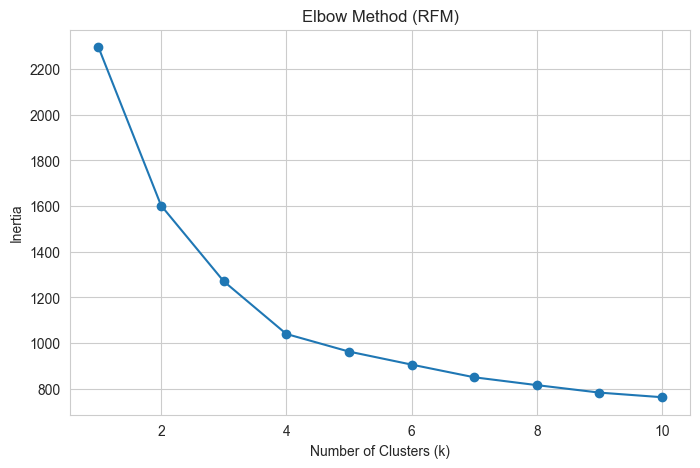

Cluster Summary:


,Recency,Frequency,Monetary,Category Preference
Cluster,,,,
0,9.980000,13.486667,2834.668200,Books
1,77.555556,5.166667,1519.753333,Books
2,13.658120,6.290598,1606.549402,Clothing
3,11.208333,19.583333,12724.864444,Electronics
4,37.465753,11.000000,3607.407397,Clothing
5,8.250000,20.611842,5015.204145,Clothing


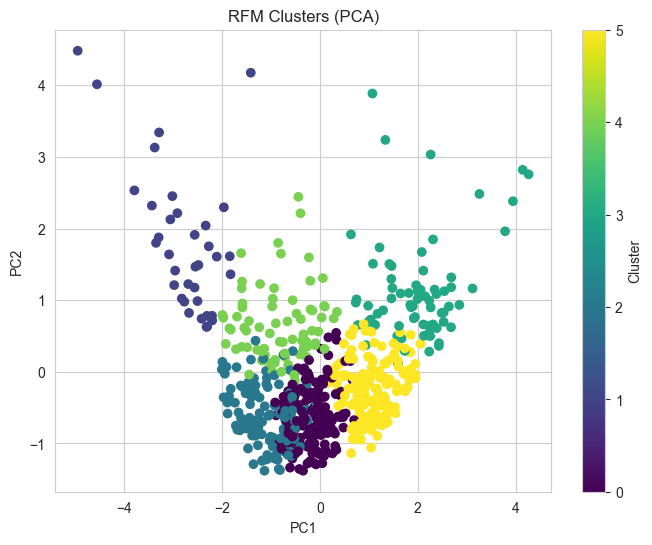

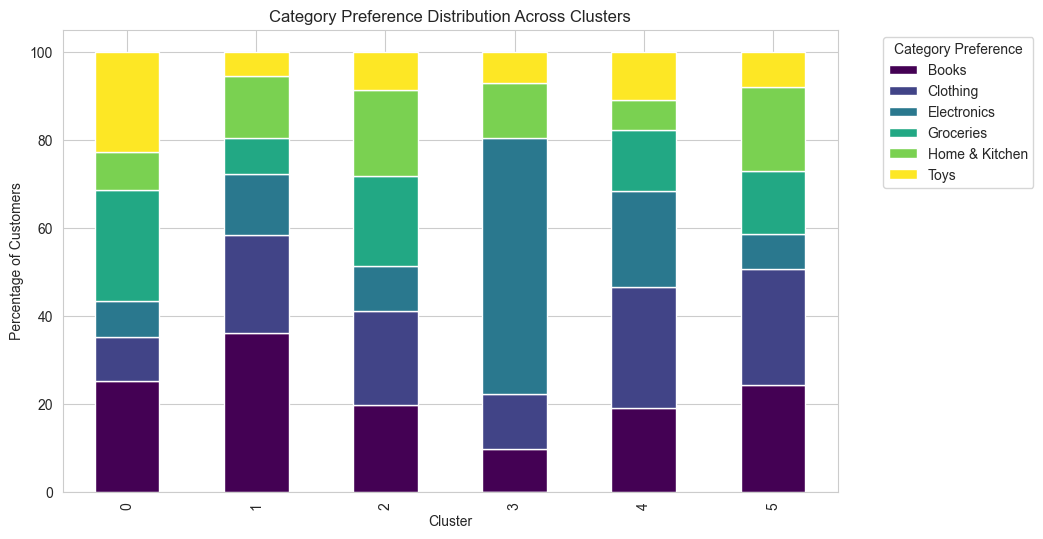

In [731]:
# Instantiating CustomerSegmentation Class
customer_segmentation = CustomerSegmentation(df)

#Preprocessing the data for adding RFM features columns
customer_segmentation.preprocess_data()

#Scaling numerical features & One-hot encoding categorical features
customer_segmentation.scale_features()

# Determining optimal number of clusters using Elbow Curve
customer_segmentation.determine_optimal_clusters()

# Applying k-Means Clustering
customer_segmentation.apply_clustering(n_clusters=6)

# Visualizing the clusters using PCA dimensionality reduction
customer_segmentation.visualize_clusters()

#Visualizing distribution of categories in each cluster
customer_segmentation.plot_category_distribution_by_cluster()

***cluster_labels = {
            0: 'Moderate Buyers',
            1: 'Potentially Churned Low value customers',
            2: 'Occasional Moderate Buyers',
            3: 'High Value Customers',
            4: 'At-risk Customers',
            5: 'Frequent Buyers'
        }***

### **Key Takeaways from Clustering Analysis**  
*RFM Feature Definitions:*  
- **Recency** → Number of days since the customer's last purchase.  
- **Frequency** → Number of times the customer has made a purchase.  
- **Monetary** → Total amount spent by the customer.  

#### **Clustering Observations**
1. **Combining numerical (RFM) and categorical (product/category preference) features** did not yield well-separated clusters.  
   - A **tiered approach**—clustering on RFM first, then incorporating categorical preferences—makes more sense.  
   - Categorical preferences might be **better utilized in recommendations** rather than clustering.  

2. **Choosing the Number of Clusters (k):**  
   - The elbow curve suggested **k between 4 and 6**.  
   - **6 clusters** were chosen based on **PCA visualization**, allowing more **granularity for recommendations**.  

3. **K-Means Suitability:**  
   - Works well for this scenario since there are **only four key features**.  
   - A simple, interpretable model that effectively captures **spending patterns**.

---

### **Cluster Labels & Descriptions**
Each cluster was labeled based on **distinct purchase behaviors:**

- **Moderate Buyers (Cluster 0)** → Regular shoppers with average spending and no extreme recency or inactivity.  
- **Potentially Churned Low-Value Customers (Cluster 1)** → Low spending, long recency—signs of infrequent shopping and possible churn.  
- **Occasional Moderate Buyers (Cluster 2)** → Buy occasionally with moderate spend but lack frequency or high value.  
- **High-Value Customers (Cluster 3)** → Spend significantly, purchasing frequently and/or recently—top-tier buyers.  
- **At-Risk Customers (Cluster 4)** → Show declining or inconsistent purchasing patterns, requiring re-engagement.  
- **Frequent Buyers (Cluster 5)** → Shop regularly but may not spend as much as high-value customers.

---

### **Key Insights**
1. **Electronics Dominates High-Value Customers**  
   - *370 users (142% higher than the second most popular category) prefer Electronics over Home & Kitchen.*  

2. **Category Preferences Indicate Engagement & Churn Risks**  
   - *Potentially Churned Customers favor Books.*  
   - *At-Risk Customers prefer Clothing.*  
   - *These groups may benefit from diversified recommendations to re-engage them.*  

3. **Toys Are a Key Interest for Moderate Buyers**  
   - *~22% of Moderate Buyers prefer Toys, the highest percentage across clusters.*  

4. **PCA Visualization Reveals Clear Segments**  
   - **High-Value Customers, At-Risk Customers, and Moderate Buyers** are **visibly distinct**, supporting the effectiveness of segmentation.


## **Baseline Approach: Collaborative & Content-Based Filtering**
Given the **small dataset size** and the **sparsity** of the item-user interaction matrix, a **neural network approach** was not ideal. Instead, a **hybrid model**—combining **Collaborative Filtering** and **Content-Based Filtering**—was explored, leveraging additional **user behavior features** beyond just interactions.

#### **Feature Considerations for Training**
- **User Features:**  
  - Purchase behavior → *Frequency of purchase, recency of purchase.*  
  - Preference → *Most frequently bought product/category.*  

- **Product Features:**  
  - Category → *Product category as a defining attribute.*  
  - Popularity → *Total purchase count across all users.*  

- **Temporal Features:**  
  - Purchase timing → *Day of the week when the purchase occurred.*  
  - Recency → *Time since the last purchase for each user.*  


##### The baseline model with just the user-product interaction matrix based collaborative filtering is not able to capture user behavior to provide accurate recommendations, so I thought of a hybrid approach, clustering + content-based filtering which can account for both user behavior driven by clustering and product-product interactions using CBF and is computationally efficient and fit for small scale data.

## Recommendation System: Clustering + Content Based Filtering

In [736]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import random

class RecommendationSystem(CustomerSegmentation):
    def __init__(self, df):
        """
        Initialize the recommendation system, inheriting from CustomerSegmentation.

        Args:
        - df: Transaction Data (Customer ID, Product ID, Category, Purchase Amount, Date)
        """
        super().__init__(df)  # Calls CustomerSegmentation's init method
        self.df = df
        self.segmentation = False
        # Ensure Clustering Data is Processed Before Proceeding
        self.preprocess_data()  # This sets self.rfm_df
        self.apply_clustering()  # Ensures self.rfm_df has clusters assigned
        
        self.similarity_matrix = None
        self.product_index_map = None

    def compute_product_embeddings(self, df_products):
        """
        Generates product embeddings using TF-IDF for content-based filtering.

        Args:
            df_products (DataFrame): Product catalog with 'Product ID' & 'Product Category'.

        Returns:
            similarity_matrix (ndarray): Cosine similarity matrix.
            product_index_map (dict): Mapping of product IDs to matrix indices.
        """
        df_products['product_text'] = df_products['Product Category']
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(df_products['product_text'])

        self.similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
        self.product_index_map = {pid: idx for idx, pid in enumerate(df_products['Product ID'])}

    def get_cbf_recommendations(self, user_id, top_n=5):
        """
        Hybrid Recommendation:
        - Identify user's cluster
        - Get high frequency products in that cluster
        - Rank & recommend similar items using content-based filtering (TF-IDF)
        - 1 out of 10 times, recommend a product **outside** the cluster for diversity.
        - 1 out of 10 times, recommend a product **from the closest cluster**.

        Returns:
            List of recommended product IDs.
        """
        # ✅ Step 1: Get User's Cluster (Using Inherited Method)
        cluster_id = self.get_user_cluster(user_id)
        if cluster_id is None:
            return None

        print(f"User {user_id} belongs to Cluster {cluster_id}")

        # ✅ Step 2: Get Users in the Same Cluster & Their Transactions
        # self.rfm_df = self.rfm_df.reset_index()
        cluster_users = self.rfm_df[self.rfm_df['Cluster'] == cluster_id].index.tolist()
        cluster_transactions = self.df[self.df['Customer ID'].isin(cluster_users)]

        df_products = cluster_transactions[['Product ID', 'Product Category']].drop_duplicates()

        # ✅ Step 3: Rank Products by Popularity
        popular_products = (
            cluster_transactions.groupby('Product ID')
            .agg({'Purchase Amount': 'sum', 'Customer ID': 'count'})
            .rename(columns={'Purchase Amount': 'total_revenue', 'Customer ID': 'purchase_count'})
            .sort_values(by='total_revenue', ascending=False)
            .reset_index()
        )

        # ✅ Step 4: Get the Most Popular Product in the Cluster
        if popular_products.empty:
            print("No popular products found in this cluster.")
            return None
        top_product = popular_products.iloc[0]['Product ID']

        # ✅ Step 5: Compute Product Similarity using CBF (TF-IDF)
        self.compute_product_embeddings(df_products)

        # ✅ Step 6: Find Top Similar Products
        if top_product not in self.product_index_map:
            print(f"Top product {top_product} not found in product index.")
            return None

        product_idx = self.product_index_map[top_product]
        sim_scores = self.similarity_matrix[product_idx]

        # ✅ Step 7: Get Top Similar Products
        top_similar_indices = np.argsort(-sim_scores)[1:top_n+1]  # Exclude itself
        similar_product_ids = [df_products.iloc[i]['Product ID'] for i in top_similar_indices]

        # ✅ Step 8: Introduce a Product Outside the Cluster (1 in 10 times)
        if random.random() < 0.1:
            all_product_ids = self.df['Product ID'].unique()
            random_product = np.random.choice(all_product_ids)
            similar_product_ids[-1] = random_product  # Replace the last recommendation
            print(f"🔀 Introducing a random product outside the cluster: {random_product}")

        # ✅ Step 9: Introduce a Product from the Closest Cluster (1 in 10 times)
        if random.random() < 0.1:
            closest_cluster = self.get_closest_cluster(cluster_id)
            if closest_cluster is not None:
                closest_cluster_products = self.get_cluster_products(closest_cluster)
                if closest_cluster_products.size > 0:
                    cluster_product = np.random.choice(closest_cluster_products)
                    similar_product_ids[-2] = cluster_product  # Replace second last recommendation
                    print(f"🔀 Introducing a product from closest cluster {closest_cluster}: {cluster_product}")

        return similar_product_ids

    def get_closest_cluster(self, cluster_id):
        """
        Finds the closest cluster based on numeric similarity (e.g., using cluster means).
    
        Args:
            cluster_id (int): The cluster ID of the user.
    
        Returns:
            int: Closest cluster ID.
        """
        # ✅ Step 1: Compute mean RFM values for each cluster
        cluster_means = self.rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
    
        # ✅ Step 2: Compute Euclidean distances from the given cluster
        cluster_distances = np.linalg.norm(cluster_means.values - cluster_means.loc[cluster_id].values, axis=1)
    
        # ✅ Step 3: Get closest cluster (excluding itself)
        cluster_indices = np.arange(len(cluster_means))  # Numeric cluster index mapping
        valid_indices = cluster_indices != cluster_id  # Mask to exclude self
    
        closest_cluster = cluster_indices[valid_indices][np.argmin(cluster_distances[valid_indices])]
    
        return closest_cluster


    def get_cluster_products(self, cluster_id):
        """
        Fetches products frequently purchased in the given cluster.
        
        Args:
            cluster_id (int): The cluster ID for which products are to be fetched.
        
        Returns:
            np.array: Unique product IDs purchased by users in the given cluster.
        """
        # ✅ Step 1: Get Customer IDs mapped to this cluster
        cluster_users = self.df[self.df['Customer ID'].isin(self.rfm_df.index[self.rfm_df['Cluster'] == cluster_id])]['Customer ID'].unique()
        
        # ✅ Step 2: Filter transactions for these users
        cluster_transactions = self.df[self.df['Customer ID'].isin(cluster_users)]
        
        if cluster_transactions.empty:
            return None
    
        # ✅ Step 3: Return Unique Product IDs
        return cluster_transactions['Product ID'].unique()



In [737]:
# 🔹 Example: Get Recommendations for a User
user_id = 'C0011'
recommender = RecommendationSystem(df)

recommended_products = recommender.get_cbf_recommendations(user_id, top_n=5)

if recommended_products:
    print(f"🔹 Recommended Products for User {user_id}: {recommended_products}")



User C0011 belongs to Cluster 0
🔀 Introducing a product from closest cluster 4: P0019
🔹 Recommended Products for User C0011: ['P0046', 'P0041', 'P0022', 'P0019', 'P0049']


### Recommendation Evaluation

In [ ]:
import numpy as np
import pandas as pd

class RecommendationEvaluator:
    """
    Evaluates a recommendation system using train-test split and computes 
    Precision@K and Recall@K for user-item recommendations.
    """

    def __init__(self, recommender, df, test_size=0.2, seed=42):
        """
        Initialize the evaluator with a trained recommendation system and perform train-test split.

        Args:
            recommender (RecommendationSystem): Instance of trained RecommendationSystem.
            df (pd.DataFrame): Full transaction dataset containing 'Customer ID' and 'Product ID'.
            test_size (float): Proportion of items per user to be included in the test set.
            seed (int): Random seed for reproducibility.
        """
        self.recommender = recommender  # Store the recommendation system instance
        self.user_list = df['Customer ID'].unique()  # Extract list of unique users
        self.df_train, self.df_test = self.train_test_split_by_user(df, test_size, seed)  # Perform train-test split
        self.test_items_dict = self._build_test_items_dict()  # Create test data lookup dictionary

    def train_test_split_by_user(self, df, test_size=0.2, seed=42):
        """
        Splits the dataset into train and test, ensuring each user has 'test_size' fraction of items in the test set.

        Args:
            df (pd.DataFrame): Full transaction dataset.
            test_size (float): Fraction of items per user to be included in the test set.
            seed (int): Random seed for reproducibility.

        Returns:
            df_train (pd.DataFrame): Training set (remaining items for each user).
            df_test (pd.DataFrame): Test set (randomly sampled test_size fraction of items per user).
        """
        np.random.seed(seed)  # Set seed for reproducibility
        train_rows = []  # List to store training row indices
        test_rows = []  # List to store test row indices

        # Iterate through each user and split their transactions
        for user_id, group in df.groupby('Customer ID'):
            items = group.index.tolist()  # Get all transactions for the user
            n_test = int(len(items) * test_size)  # Calculate number of items for test set
            
            # Randomly select 'n_test' transactions for test set
            test_indices = np.random.choice(items, size=n_test, replace=False)

            # Assign transactions to train or test sets
            for idx in items:
                if idx in test_indices:
                    test_rows.append(idx)
                else:
                    train_rows.append(idx)

        # Create train and test dataframes
        df_train = df.loc[train_rows].reset_index(drop=True)
        df_test = df.loc[test_rows].reset_index(drop=True)

        return df_train, df_test

    def _build_test_items_dict(self):
        """
        Creates a dictionary mapping each user to a set of their test products.

        Returns:
            dict: {Customer ID -> Set of product IDs in the test set}
        """
        return self.df_test.groupby('Customer ID')['Product ID'].apply(set).to_dict()

    def precision_recall_at_k(self, K=5):
        """
        Calculates average Precision@K and Recall@K over provided users.

        Args:
            K (int): Number of recommendations per user.

        Returns:
            avg_precision (float): Average precision at K.
            avg_recall (float): Average recall at K.
        """
        precisions, recalls = [], []  # Lists to store precision and recall values per user

        # Iterate over all users in the dataset
        for user_id in self.user_list:
            if user_id not in self.test_items_dict:
                continue  # Skip users without test items
            
            true_items = self.test_items_dict[user_id]  # Retrieve actual items purchased by the user
            
            # Get recommendations from the recommender system
            recommended = self.recommender.get_cbf_recommendations(user_id, top_n=K)

            if recommended is None:  
                continue  # Skip if no recommendations were generated

            # Compute the number of correctly recommended items
            hits = len(true_items & set(recommended))  

            # Compute Precision@K: Hits / min(K, actual number of test items)
            prec = hits / min(K, len(true_items))  

            # Compute Recall@K: Hits / total number of test items
            rec = hits / len(true_items) if len(true_items) > 0 else 0  

            # Store the computed precision and recall
            precisions.append(prec)
            recalls.append(rec)

        # Compute average precision and recall across all users
        avg_precision = np.mean(precisions) if precisions else 0
        avg_recall = np.mean(recalls) if recalls else 0

        return avg_precision, avg_recall


In [742]:
# RecommendationEvaluator
recommendation_evaluator = RecommendationEvaluator(recommender, df)

#Evaluating Precision & Recall for the Recommender Results
avg_prec, avg_rec = recommendation_evaluator.precision_recall_at_k(K=5)

display("Precision: ", avg_prec)
display("Recall: ", avg_rec)

{'P0060'}
User C0001 belongs to Cluster 2
{'P0001', 'P0034', 'P0005'}
User C0002 belongs to Cluster 5
{'P0022', 'P0048', 'P0020'}
User C0003 belongs to Cluster 0
🔀 Introducing a random product outside the cluster: P0039
{'P0040', 'P0010'}
User C0004 belongs to Cluster 4
{'P0014', 'P0053'}
User C0005 belongs to Cluster 0
{'P0028'}
User C0006 belongs to Cluster 2
🔀 Introducing a random product outside the cluster: P0023
🔀 Introducing a product from closest cluster 1: P0028
{'P0005', 'P0012'}
User C0007 belongs to Cluster 0
{'P0010'}
User C0008 belongs to Cluster 2
{'P0046', 'P0059', 'P0028', 'P0058'}
User C0009 belongs to Cluster 3
{'P0031', 'P0019'}
User C0010 belongs to Cluster 0
{'P0040', 'P0045', 'P0016'}
User C0011 belongs to Cluster 0
{'P0060', 'P0054', 'P0020'}
User C0012 belongs to Cluster 3
{'P0013'}
User C0013 belongs to Cluster 2
{'P0013'}
User C0014 belongs to Cluster 1
{'P0007', 'P0009'}
User C0015 belongs to Cluster 0
{'P0014', 'P0002', 'P0043'}
User C0016 belongs to Cluste

'Precision: '

0.11861861861861861

'Recall: '

0.11861861861861861

### **Model Comparison & Rationale for Selection**  

#### **Limitations**
- The dataset is **synthetic**, mimicking real-world patterns but lacking actual user interactions.  
- **Performance metrics alone** are not fully reliable; interpretability and logical consistency were prioritized.

---

### **Model Selection Process**
1. **Collaborative Filtering (Baseline Model)**  
   - Initially tried **matrix-based CF** leveraging RFM features.  
   - **Did not perform well** due to limited user interactions and small dataset size.  

2. **Clustering + Content-Based Hybrid Approach**  
   - **PCA visualizations** indicated strong **RFM & category preference associations**.  
   - Combined **clustering (user segmentation) with content-based filtering** for better recommendations.  

3. **Matrix Factorization (Explored but Not Used)**  
   - Uncovers **latent relationships**, but **overfits** on small datasets.  
   - **Not suitable** for this scenario.

---

### **Implemented Approach: Clustering + Content-Based Filtering**
A **hybrid recommendation system** combining **K-Means clustering** and **TF-IDF-based content filtering**.

#### **Steps:**
✅ **User Clustering** → Groups users based on RFM behavior.  
✅ **Content-Based Filtering** → Recommends items from the same cluster.  
✅ **TF-IDF for Category Importance** → Weights categories beyond just purchase frequency.  
✅ **Hybrid Model** → Blends user clustering & item similarity for better recommendations.  
✅ **Diversity Mechanism** → 1 in 10 recommendations:  
   - **From the closest cluster** (ensuring some similarity).  
   - **A random product** (exploring new categories).  

 *This approach works well even on synthetic data and is expected to scale better with real-world interactions.*

---

### **Why Not Use Neural Networks or Two-Tower Models?**
1. **Lack of High-Dimensional Features** → No text embeddings; NN requires **richer data**.  
2. **Small Dataset** → NN needs **large-scale** data; **overfits on small datasets**.  
3. **Two-Tower Models Are Overkill** → Designed for **real-time, large-scale recommendations**, **not needed here**.  



#### Matrix Factorization

In [567]:
# from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
# import pandas as pd
# 
# # ✅ Normalize numerical features for inclusion
# scaler = MinMaxScaler()
# df_feat[['Recency', 'Purchase Frequency', 'Total Spend', 'Product Popularity']] = \
#     scaler.fit_transform(df_feat[['Recency', 'Purchase Frequency', 'Total Spend', 'Product Popularity']])
# 
# # ✅ Encode categorical features
# user_encoder = LabelEncoder()
# product_encoder = LabelEncoder()
# category_encoder = LabelEncoder()
# 
# df_feat['Customer ID Encoded'] = user_encoder.fit_transform(df_feat['Customer ID'])
# df_feat['Product ID Encoded'] = product_encoder.fit_transform(df_feat['Product ID'])
# df_feat['Product Category Encoded'] = category_encoder.fit_transform(df_feat['Product Category'])
# 
# # ✅ Create a new feature-enhanced user-item matrix
# user_product_matrix = df_feat.pivot_table(
#     index='Customer ID Encoded',
#     columns='Product ID Encoded',
#     values='Purchase Frequency',
#     fill_value=0
# )
# 
# # ✅ Merge user features with the interaction matrix
# user_features = df_feat[['Customer ID Encoded', 'Recency', 'Purchase Frequency', 'Total Spend']]
# user_features = user_features.reindex(user_product_matrix.index, fill_value=0)
# 
# # ✅ Merge product features with the interaction matrix
# # ✅ Ensure product features are aligned with the unique products
# product_features = df_feat[['Product ID Encoded', 'Product Popularity', 'Product Category Encoded']].drop_duplicates()
# 
# # ✅ Reindex product features to match user-product matrix columns
# product_features = product_features.set_index('Product ID Encoded').reindex(user_product_matrix.columns, fill_value=0)
# 
# 
# print("User-Product Matrix Shape:", user_product_matrix.shape)
# print("User Features Shape:", user_features.shape)
# print("Product Features Shape:", product_features.shape)


User-Product Matrix Shape: (600, 60)
User Features Shape: (600, 4)
Product Features Shape: (60, 2)


In [568]:
# import numpy as np
# from sklearn.decomposition import NMF
# 
# # ✅ Stack user features as extra columns
# user_matrix = np.hstack([user_product_matrix, user_features])
# 
# # ✅ Stack product features as extra rows
# product_matrix = np.hstack([user_product_matrix.T, product_features])
# 
# # ✅ Train NMF on User Matrix
# nmf_model_user = NMF(n_components=50, init='random', random_state=42)
# W_nmf_user = nmf_model_user.fit_transform(user_matrix)  # User Latent Features
# 
# # ✅ Train NMF on Product Matrix
# nmf_model_product = NMF(n_components=50, init='random', random_state=42)
# H_nmf_product = nmf_model_product.fit_transform(product_matrix.T)  # Product Latent Features
# 
# print(f"User Latent Features: {W_nmf_user.shape}, Product Latent Features: {H_nmf_product.shape}")


User Latent Features: (600, 50), Product Latent Features: (602, 50)


In [569]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# 
# # ✅ Convert User-Item Matrix to NumPy
# user_product_matrix_np = user_product_matrix.values
# 
# # ✅ Create a Train Matrix (Copy of Original)
# train_matrix = user_product_matrix_np.copy()
# 
# # ✅ Mask a fraction of interactions for test set
# test_ratio = 0.2  # 20% of interactions as test
# test_mask = (np.random.rand(*user_product_matrix_np.shape) < test_ratio)
# 
# # ✅ Apply Mask: Set 20% of purchases to 0 for training
# train_matrix[test_mask] = 0
# 
# # ✅ Create Test Matrix (only removed interactions)
# test_matrix = user_product_matrix_np - train_matrix  # Test contains only removed interactions
# 
# # ✅ Convert back to DataFrames (for later use)
# train_df = pd.DataFrame(train_matrix, index=user_product_matrix.index, columns=user_product_matrix.columns)
# test_df = pd.DataFrame(test_matrix, index=user_product_matrix.index, columns=user_product_matrix.columns)
# 
# print(f"Train Matrix Shape: {train_df.shape}, Test Matrix Shape: {test_df.shape}")


Train Matrix Shape: (600, 60), Test Matrix Shape: (600, 60)


In [570]:
# from sklearn.decomposition import NMF
# 
# # ✅ Train NMF on Train Data Only
# nmf_model = NMF(n_components=50, init='random', random_state=42)
# W_nmf = nmf_model.fit_transform(train_matrix)
# H_nmf = nmf_model.components_
# 
# # ✅ Reconstruct the Full Matrix (Predicted Scores)
# predicted_matrix = np.dot(W_nmf, H_nmf)
# 
# # ✅ Convert back to DataFrame for easy indexing
# predicted_df = pd.DataFrame(predicted_matrix, index=user_product_matrix.index, columns=user_product_matrix.columns)
# 
# print("🔍 Predicted Scores Shape:", predicted_df.shape)


🔍 Predicted Scores Shape: (600, 60)


In [571]:
# def precision_recall_at_k(test_df, predicted_df, k=5):
#     """
#     Compute Precision@K and Recall@K for NMF.
#     """
#     precisions = []
#     recalls = []
#     
#     for user_id in test_df.index:
#         # ✅ Get actual purchased items (test set)
#         true_items = set(test_df.loc[user_id][test_df.loc[user_id] > 0].index)
#         
#         # ✅ Get top-K recommended items
#         recommended_items = predicted_df.loc[user_id].sort_values(ascending=False).head(k).index
#         recommended_set = set(recommended_items)
#         
#         # ✅ Compute Hits
#         hits = len(true_items & recommended_set)
#         
#         # ✅ Compute Precision & Recall
#         precision = hits / k
#         recall = hits / len(true_items) if len(true_items) > 0 else 0
#         
#         precisions.append(precision)
#         recalls.append(recall)
#     
#     avg_precision = np.mean(precisions)
#     avg_recall = np.mean(recalls)
#     
#     return avg_precision, avg_recall
# 
# # ✅ Evaluate NMF Model
# precision, recall = precision_recall_at_k(test_df, predicted_df, k=5)
# 
# print(f"📊 Precision@5: {precision:.4f}, Recall@5: {recall:.4f}")


📊 Precision@5: 0.0013, Recall@5: 0.0039


In [555]:
# import numpy as np
# 
# # ✅ Reconstruct the predicted user-product interaction scores (Train Only)
# predicted_scores_train = np.dot(W_train, H_train)
# 
# # ✅ Convert back to DataFrame using original Customer & Product IDs
# predicted_ratings_df_train = pd.DataFrame(
#     predicted_scores_train, 
#     index=user_product_matrix_train.index,  
#     columns=user_product_matrix_train.columns  
# )
# 
# print(predicted_ratings_df_train.head())  # Check predicted scores


Product ID      P0001     P0002     P0003         P0004     P0005     P0006  \
Customer ID                                                                   
C0001        0.000000  0.005256  0.010390  1.481856e-03  0.005013  0.000567   
C0002        0.000000  0.018064  0.000000  0.000000e+00  0.000000  0.742707   
C0003        0.000392  0.264540  0.010330  3.413033e-07  0.001848  0.001168   
C0004        0.000000  0.013813  0.052827  1.130874e-02  0.000000  0.001249   
C0005        0.000917  0.184837  0.005305  3.833448e-01  0.380484  0.026363   

Product ID      P0007     P0008     P0009     P0010  ...         P0051  \
Customer ID                                          ...                 
C0001        0.000000  0.002219  0.000000  0.007021  ...  8.946650e-07   
C0002        0.000000  0.000000  0.000000  0.000000  ...  1.817956e-07   
C0003        0.024702  0.002863  0.000000  0.010973  ...  5.700731e-01   
C0004        0.000000  0.012802  0.006551  0.000000  ...  5.743123e-05   
C0